In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# Function for basis_details_decomposition (Corresponds to equation 10 and 11 from the article)
def basis_details_decomposition(images_tuple, avg_size=31):
    kernel = np.ones((avg_size, avg_size), np.float32) / avg_size ** 2
    basis_list = []
    details_list = []
    for im in images_tuple:
        basis = cv2.filter2D(im, -1, kernel)
        details = im - basis
        basis_list.append(basis)
        details_list.append(im - basis)
    return tuple(basis_list), tuple(details_list)


# Function for saliencies (laplacian filter + gaussian lowpass filter)
# Corresponds to equation 13 in the article
def saliency_maps(images_tuple, lapsize, rg, sigmag):
    saliency_list = []
    for im in images_tuple:
        laplacian = cv2.Laplacian(im, cv2.CV_64F, ksize=lapsize)
        abs_laplacian = np.abs(laplacian)
        saliency = cv2.GaussianBlur(abs_laplacian, (2 * rg + 1, 2 * rg + 1), sigmaX=sigmag)
        saliency_list.append(saliency)
        s=np.array(saliency_list)
        saliency_list_normalized=list(s/np.sum(s,axis=0))
    return tuple( saliency_list_normalized)


# Weight map function (corresponds to equation (14) from the arcticle)
def weight_map_construction(saliency_tuple):
    # Intialize weight maps to zero
    dims = saliency_tuple[0].shape
    nims = len(saliency_tuple)
    
    weight_maps = [np.zeros(dims, dtype=int) for i in range(0, nims)]
    
    argmax=np.argmax(saliency_tuple,axis=0)
    # Use that information to fill the weight maps
    for i in range(0, nims):
        # Get the indicator for each pixel and fill the corresponding arrays
        weight_maps[i]= (argmax == i).astype(int)
    return weight_maps


# Produce refined weights maps using guided filtering (Function for equations 15 and 16 of the article)
def refined_weight_maps(guides_tuple, images_tuple, r, eps):
    nims = len(images_tuple)
    outputs = []
    for i in range(0, nims):
        filtered = cv2.ximgproc.guidedFilter(cv2.convertScaleAbs(guides_tuple[i]), images_tuple[i], r, eps)
        outputs.append(filtered)
    return tuple(outputs)


# Pixel by pixel normalization
def weight_maps_normalization(weights_tuple):
    
    weights_list=np.array(weights_tuple)
    weights_list=cv2.convertScaleAbs(weights_list*255)
    weights_list=np.array(weights_list,dtype=float)/255
    weights_list_normalized=list(weights_list/np.sum(weights_list,axis=0))
    return tuple(weights_list_normalized)


def images_weighted_average(weights_tuple, images_tuple):
    size=np.array(weights_tuple).shape+(1,)
    return np.sum(np.array(weights_tuple).reshape(size) * np.array(images_tuple), axis=0)








In [111]:
##################### Loadings and other prerequisites #############################################################

# Path to the data
path = os.getcwd() + "/Data/"

# Load two images with different focus
image1 = cv2.imread(path + "jug1.png")
image2 = cv2.imread(path + "jug2.png")




In [112]:
# Plot them
cv2.imshow("jug1", image1)
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)


-1

In [113]:
cv2.imshow("jug2", image2)
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)

-1

In [114]:
# ################### A : Two scales image decomposition ###########################################################

images = (image1, image2)
images_gray=tuple([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

# Size of averaging kernel for basis/details decomposition
avg_size = 31
# Get basis and details images
bases_tuple, details_tuple = basis_details_decomposition(images, avg_size)
# See result of basis/details decomposition
cv2.imshow("basis1", bases_tuple[0])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)
cv2.imshow("details1", details_tuple[0])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)



-1

In [115]:
# ################### B : Weight map construction with guided filtering ############################################

# Laplacian filter size
lapsize = 3
# Parameters for Gaussian lowpass filter
rg = 5
sigmag = 5
# Compute laplacians
saliency_tuple = saliency_maps(images_gray, lapsize, rg, sigmag)
cv2.imshow("saliency1", saliency_tuple[1])
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)


-1

Text(0.5,1,'Weight map 1 for details')

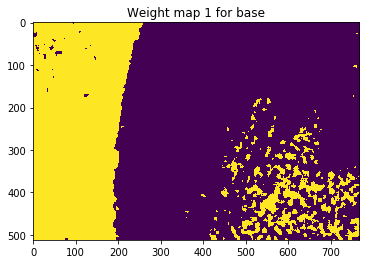

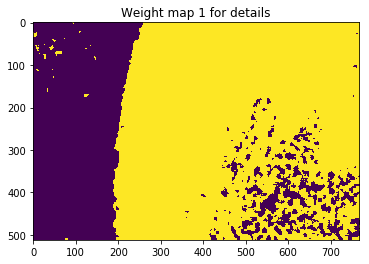

In [103]:
# Get the weight maps
weight_maps = weight_map_construction(saliency_tuple)
# Vizualize weight map, we multiply by 255 to distinguish the pixel equal to 1 from those equal to 0
plt.figure()
plt.imshow(255 * weight_maps[0])
plt.title("Weight map 1 for base")
plt.figure()
plt.imshow(255 * weight_maps[1])
plt.title("Weight map 1 for details")



In [104]:
# Refined weight maps using guided filtering
eps1 = 0.3
r1 = 45
refined_wm_basis = refined_weight_maps(weight_maps, images_gray, r1, eps1)
eps2 = 1e-6
r2 = 7
refined_wm_details = refined_weight_maps(weight_maps, images_gray, r2, eps2)



In [105]:
# Normalization of weight maps
refined_normalized_bases = weight_maps_normalization(refined_wm_basis)
refined_normalized_details = weight_maps_normalization(refined_wm_details)



In [106]:
# Fused basis and fused details
fused_bases = images_weighted_average(refined_normalized_bases, bases_tuple)
fused_details = images_weighted_average(refined_normalized_details, details_tuple)




In [109]:
# Fused image
fused_image = fused_bases + fused_details
fused_image_uint8 = cv2.convertScaleAbs(fused_image)
cv2.imshow("Fused image", fused_image_uint8)
cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)

-1